<a href="https://colab.research.google.com/github/Komal-Zia/Assignment002/blob/main/Neural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install pyemd tensorflow scikit-learn matplotlib


PyEMD successfully imported!
Please upload your dataset CSV file.


Saving IMF2.csv to IMF2 (4).csv
Dataset loaded successfully!


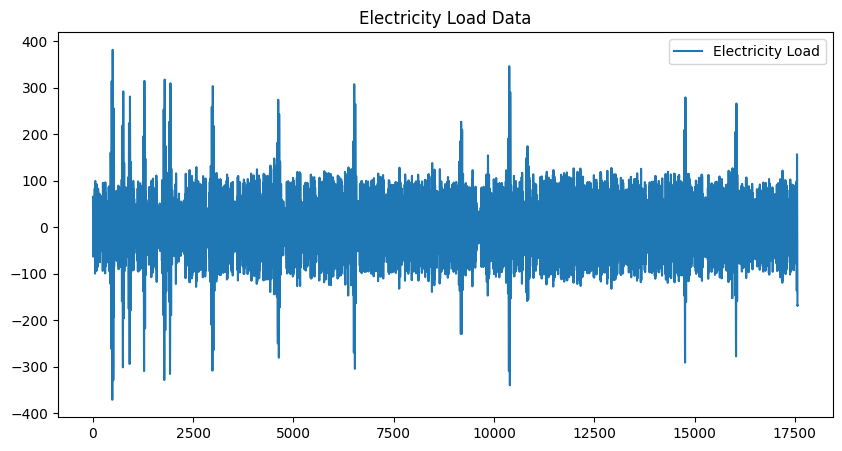

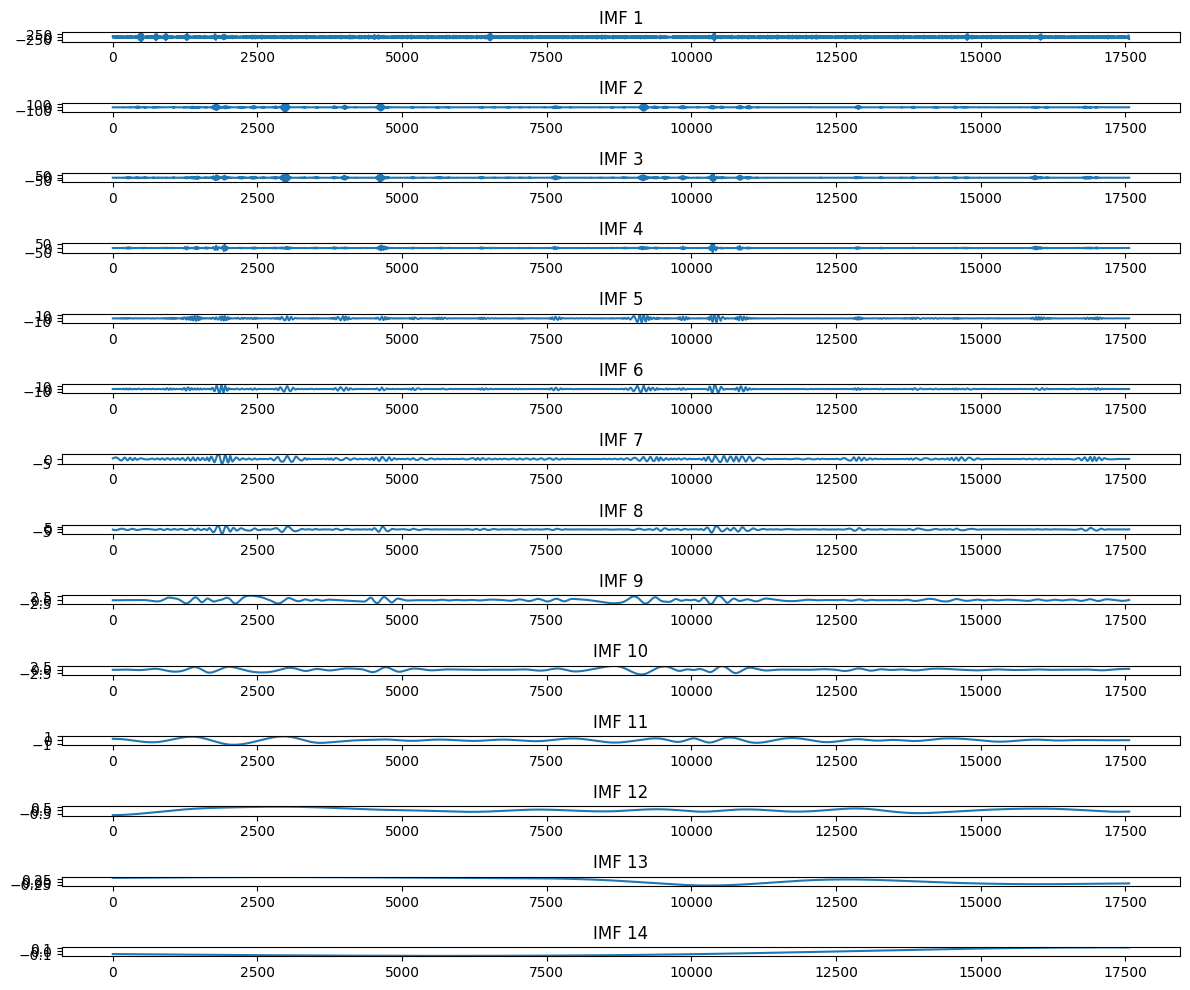

In [10]:
!pip install EMD-signal
from PyEMD import CEEMDAN
print("PyEMD successfully imported!")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PyEMD import CEEMDAN
from sklearn.preprocessing import MinMaxScaler

# Load and preprocess the dataset
def load_and_decompose(file_path):
    # Load dataset
    data = pd.read_csv(file_path)
    print("Dataset loaded successfully!")

    # Plot the data
    plt.figure(figsize=(10, 5))
    plt.plot(data.iloc[:, 1], label='Electricity Load')
    plt.title("Electricity Load Data")
    plt.legend()
    plt.show()

    # Decompose using CEEMDAN
    ceemdan = CEEMDAN()
    load_series = data.iloc[:, 1].values  # Assuming the load column is the second column
    IMFs = ceemdan(load_series)

    # Plot IMFs
    plt.figure(figsize=(12, 10))
    for i, imf in enumerate(IMFs):
        plt.subplot(len(IMFs), 1, i + 1)
        plt.plot(imf)
        plt.title(f"IMF {i + 1}")
    plt.tight_layout()
    plt.show()

    return IMFs

# Call the function for data upload in Colab
from google.colab import files
print("Please upload your dataset CSV file.")
uploaded = files.upload()
dataset_path = list(uploaded.keys())[0]

IMFs = load_and_decompose(dataset_path)


In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Lambda
import tensorflow as tf

# Define the CLDNM model
def create_cldnm(input_shape):
    input_layer = Input(shape=input_shape)

    # LSTM Layer
    lstm_out = LSTM(64, return_sequences=False)(input_layer)

    # Dendritic Layer
    def dendritic_layer(x):
        nonlinear_transform = tf.nn.relu(x)
        dendritic_product = tf.reduce_prod(nonlinear_transform, axis=-1, keepdims=True)
        return dendritic_product

    dendritic_out = Lambda(dendritic_layer)(lstm_out)

    # Dense Output Layer
    output_layer = Dense(1, activation='linear')(dendritic_out)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.summary()
    return model



In [12]:
from sklearn.model_selection import train_test_split

# Prepare the dataset for training
# Update dataset preparation to return scaler
def prepare_dataset(IMFs, time_steps=10):
    scaler = MinMaxScaler()
    X, y = [], []

    for imf in IMFs:
        scaled_imf = scaler.fit_transform(imf.reshape(-1, 1))
        for i in range(len(scaled_imf) - time_steps):
            X.append(scaled_imf[i:i+time_steps])
            y.append(scaled_imf[i+time_steps])

    return np.array(X), np.array(y), scaler  # Return scaler


# Prepare the dataset and capture the scaler
X, y, scaler = prepare_dataset(IMFs)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train the model
from tensorflow.keras.optimizers import Adam

model = create_cldnm(input_shape=(X.shape[1], X.shape[2]))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 10, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │               2 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,898 (66.01 KB)

 Trainable params: 16,898 (66.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 57s 9ms/step - loss: 0.0669 - mae: 0.1811 - val_loss: 0.0323 - val_mae: 0.1126
Epoch 2/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - loss: 0.0323 - mae: 0.1117 - val_loss: 0.0323 - val_mae: 0.1116
Epoch 3/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - loss: 0.0322 - mae: 0.1117 - val_loss: 0.0323 - val_mae: 0.1116
Epoch 4/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 0.0322 - mae: 0.1118 - val_loss: 0.0323 - val_mae: 0.1116
Epoch 5/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 50s 8ms/step - loss: 0.0320 - mae: 0.1112 - val_loss: 0.0323 - val_mae: 0.1126
Epoch 6/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 0.0319 - mae: 0.1108 - val_loss: 0.0323 - val_mae: 0.1115
Epoch 7/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 81s 9ms/step - loss: 0.0321 - mae: 0.1112 - val_loss: 0.0323 - val_mae: 0.1121
Epoch 8/50
6145/6145 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0320 - mae: 0.1113 - val_loss: 0.0323 - val_mae: 0.1122
Epoch 9/50
6145/6145 ━━━━━━━━━━━

In [15]:
# Step 1: Predict values using the trained model
y_pred = model.predict(X_test)  # Ensure X_test is defined and ready

# Step 2: Denormalize data
y_test_denorm = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_denorm = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Step 3: Recalculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test_denorm, y_pred_denorm)
rmse = np.sqrt(mean_squared_error(y_test_denorm, y_pred_denorm))
mape = np.mean(np.abs((y_test_denorm - y_pred_denorm) / (y_test_denorm + 1e-6))) * 100
r2 = r2_score(y_test_denorm, y_pred_denorm)

# Step 4: Print the evaluation results
print(f"Updated Model Evaluation:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R^2: {r2}")


1537/1537 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
Updated Model Evaluation:
MAE: 0.031279388142768656
RMSE: 0.05042551230333032
MAPE: 442.5480362984369%
R^2: -0.00035492780271795255
